In [1]:
import sys, os
sys.path.insert(0, '..')

In [2]:
import graph_tool.all as gt
import graph_embeddings
from models.crosswalk import Crosswalk
from utils.score import statistical_parity
import faiss
import residual2vec as rv
import numpy as np
import pandas as pd
from scipy import sparse
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import networkx as nx
import warnings
warnings.filterwarnings("ignore")

from sklearn.neighbors import kneighbors_graph
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder



Bad key "text.kerning_factor" on line 4 in
/home/ashutosh/miniconda3/envs/study/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution
2022-08-09 19:34:45.283343: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
2022-08-09 19:34:45.303698: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2304000000 Hz
2022-08-09 19:34:45.304460: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x556f90715c00 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-08-09 19:34:45.304471: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2022-08-09 19:34:45

In [3]:

DATA_FILE = '../data/polbooks.gml'
G = nx.read_gml(DATA_FILE)
G = nx.relabel.convert_node_labels_to_integers(G, first_label=0, ordering='default')

nodes = G.nodes(data=True)
labels, group_ids = np.unique([n[1]['value'] for n in nodes], return_inverse=True)

A = nx.adjacency_matrix(G).asfptype()
deg = np.array(A.sum(axis=1)).reshape(-1)
G = nx.from_scipy_sparse_matrix(A)

models = {}
window_length = 5
num_walks = 10
dim = 128

models["unbiased"] = graph_embeddings.DeepWalk(window_length=window_length, num_walks=num_walks, restart_prob=0)

models["degree-unbiased"] = rv.residual2vec_sgd(
    noise_sampler=rv.ConfigModelNodeSampler(),
    window_length=window_length,
    num_walks=num_walks,
    cuda=True,
    walk_length=80
)

models["group-unbiased"] = rv.residual2vec_sgd(
    noise_sampler=rv.SBMNodeSampler(
        group_membership=group_ids, window_length=window_length,
    ),
    window_length=window_length,
    num_walks=num_walks,
    cuda=True,
    walk_length=80,
)

models["fairwalk"] = graph_embeddings.Fairwalk(window_length=window_length, num_walks=num_walks)
models["fairwalk-group-unbiased"] = graph_embeddings.Fairwalk(
    window_length=window_length, num_walks=num_walks, group_membership=group_ids
)
models['GCN'] = graph_embeddings.GCN()
models["gcn-doubleK"] = graph_embeddings.GCN(num_default_features=dim * 2)
models["graphsage"] = graph_embeddings.GraphSage()
models["graphsage-doubleK"] = graph_embeddings.GraphSage(num_default_features=dim * 2)
models["gat"] = graph_embeddings.GAT(layer_sizes=[64, 256])
models["gat-doubleK"] = graph_embeddings.GAT(num_default_features=dim * 2)

models['crosswalk'] = Crosswalk(group_membership=group_ids, window_length=window_length, num_walks=num_walks)

In [4]:
A[0:].todense(), A.shape

(matrix([[0., 1., 1., ..., 0., 0., 0.],
         [1., 0., 0., ..., 0., 0., 0.],
         [1., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 1.],
         [0., 0., 0., ..., 0., 1., 0.]]),
 (105, 105))

In [5]:
embs = {}

for k, model in tqdm(models.items()):
    print(model.__class__.__name__)
#     sys.stdout = open(os.devnull, 'w')
    emb = model.fit(A).transform(dim=dim)
#     sys.stdout = sys.__stdout__
    embs[k] = emb

  8%|██████████▏                                                                                                               | 1/12 [00:00<00:01,  7.40it/s]

DeepWalk
residual2vec_sgd



  0%|                                                                                                                      | 0/329 [00:00<?, ?it/s, loss=1.22]


  0%|                                                                                                                      | 0/329 [00:00<?, ?it/s, loss=1.19]


 30%|████████████████████████████████▊                                                                           | 100/329 [00:00<00:00, 335.31it/s, loss=1.1]


 30%|████████████████████████████████▊                                                                           | 100/329 [00:00<00:00, 335.31it/s, loss=1.1]


 61%|█████████████████████████████████████████████████████████████████                                          | 200/329 [00:00<00:00, 378.75it/s, loss=1.07]


 61%|████████████████████████████████████████████████████████████████▍                                         | 200/329 [00:00<00:00, 378.75it/s, loss=0.993]


 17%|████████████████████▎                                                                                                     | 2/12 [00:04<00:27,  2.79s/it]

residual2vec_sgd



  0%|                                                                                                                      | 0/329 [00:00<?, ?it/s, loss=1.36]


  0%|                                                                                                                      | 0/329 [00:00<?, ?it/s, loss=1.32]


 30%|████████████████████████████████▌                                                                          | 100/329 [00:00<00:00, 362.48it/s, loss=1.28]


 30%|████████████████████████████████▌                                                                          | 100/329 [00:00<00:00, 362.48it/s, loss=1.25]


 61%|█████████████████████████████████████████████████████████████████                                          | 200/329 [00:00<00:00, 383.39it/s, loss=1.24]


 61%|█████████████████████████████████████████████████████████████████                                          | 200/329 [00:00<00:00, 383.39it/s, loss=1.23]


 25%|██████████████████████████████▌                                                                                           | 3/12 [00:05<00:17,  1.96s/it]

Fairwalk


 33%|████████████████████████████████████████▋                                                                                 | 4/12 [00:05<00:10,  1.27s/it]

Fairwalk


 42%|██████████████████████████████████████████████████▊                                                                       | 5/12 [00:06<00:06,  1.13it/s]

GCN
Using GCN (local pooling) filters...
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAP

Epoch 50/200
1/1 [==============================] - 0s 48ms/step - loss: 0.0069 - val_loss: 0.0115
Epoch 51/200
1/1 [==============================] - 0s 48ms/step - loss: 0.0070 - val_loss: 0.0116
Epoch 52/200
1/1 [==============================] - 0s 45ms/step - loss: 0.0067 - val_loss: 0.0117
Epoch 53/200
1/1 [==============================] - 0s 55ms/step - loss: 0.0071 - val_loss: 0.0117
Epoch 54/200
1/1 [==============================] - 0s 58ms/step - loss: 0.0070 - val_loss: 0.0116
Epoch 55/200
1/1 [==============================] - 0s 57ms/step - loss: 0.0066 - val_loss: 0.0115
Epoch 56/200
1/1 [==============================] - 0s 48ms/step - loss: 0.0068 - val_loss: 0.0115
Epoch 57/200
1/1 [==============================] - 0s 55ms/step - loss: 0.0071 - val_loss: 0.0115
Epoch 58/200
1/1 [==============================] - 0s 56ms/step - loss: 0.0069 - val_loss: 0.0115
Epoch 59/200
1/1 [==============================] - 0s 51ms/step - loss: 0.0066 - val_loss: 0.0114
Epoch 60/2

 50%|█████████████████████████████████████████████████████████████                                                             | 6/12 [00:13<00:17,  2.99s/it]

GCN
Using GCN (local pooling) filters...
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAP

1/1 [==============================] - 0s 74ms/step - loss: 0.0073 - val_loss: 0.0116
Epoch 51/200
1/1 [==============================] - 0s 94ms/step - loss: 0.0071 - val_loss: 0.0116
Epoch 52/200
1/1 [==============================] - 0s 71ms/step - loss: 0.0070 - val_loss: 0.0116
Epoch 53/200
1/1 [==============================] - 0s 32ms/step - loss: 0.0070 - val_loss: 0.0117
Epoch 54/200
1/1 [==============================] - 0s 45ms/step - loss: 0.0069 - val_loss: 0.0117
Epoch 55/200
1/1 [==============================] - 0s 77ms/step - loss: 0.0069 - val_loss: 0.0118
Epoch 56/200
1/1 [==============================] - 0s 59ms/step - loss: 0.0067 - val_loss: 0.0119
Epoch 57/200
1/1 [==============================] - 0s 31ms/step - loss: 0.0070 - val_loss: 0.0119
Epoch 58/200
1/1 [==============================] - 0s 37ms/step - loss: 0.0066 - val_loss: 0.0118
Epoch 59/200
1/1 [==============================] - 0s 32ms/step - loss: 0.0069 - val_loss: 0.0119
Epoch 60/200
1/1 [=====

 58%|███████████████████████████████████████████████████████████████████████▏                                                  | 7/12 [00:21<00:22,  4.56s/it]

GraphSage
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the

2022-08-09 19:35:08.885622: W tensorflow/core/kernels/data/generator_dataset_op.cc:103] Error occurred when finalizing GeneratorDataset iterator: Cancelled: Operation was cancelled


1/1 [==============================] - 1s 590ms/step - loss: 0.7160 - binary_accuracy: 0.5000
Epoch 3/5


2022-08-09 19:35:09.531150: W tensorflow/core/kernels/data/generator_dataset_op.cc:103] Error occurred when finalizing GeneratorDataset iterator: Cancelled: Operation was cancelled


1/1 [==============================] - 1s 552ms/step - loss: 0.6862 - binary_accuracy: 0.5095
Epoch 4/5


2022-08-09 19:35:10.203932: W tensorflow/core/kernels/data/generator_dataset_op.cc:103] Error occurred when finalizing GeneratorDataset iterator: Cancelled: Operation was cancelled


1/1 [==============================] - 1s 745ms/step - loss: 0.6616 - binary_accuracy: 0.5810
Epoch 5/5


2022-08-09 19:35:10.850674: W tensorflow/core/kernels/data/generator_dataset_op.cc:103] Error occurred when finalizing GeneratorDataset iterator: Cancelled: Operation was cancelled


1/1 [==============================] - 1s 740ms/step - loss: 0.6275 - binary_accuracy: 0.6857


2022-08-09 19:35:11.519041: W tensorflow/core/kernels/data/generator_dataset_op.cc:103] Error occurred when finalizing GeneratorDataset iterator: Cancelled: Operation was cancelled


1/1 [==============================] - 0s 251ms/step


2022-08-09 19:35:12.087526: W tensorflow/core/kernels/data/generator_dataset_op.cc:103] Error occurred when finalizing GeneratorDataset iterator: Cancelled: Operation was cancelled
 67%|█████████████████████████████████████████████████████████████████████████████████▎                                        | 8/12 [00:26<00:18,  4.75s/it]

GraphSage
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the

2022-08-09 19:35:13.970430: W tensorflow/core/kernels/data/generator_dataset_op.cc:103] Error occurred when finalizing GeneratorDataset iterator: Cancelled: Operation was cancelled


1/1 [==============================] - 1s 591ms/step - loss: 0.7101 - binary_accuracy: 0.5000
Epoch 3/5


2022-08-09 19:35:14.622770: W tensorflow/core/kernels/data/generator_dataset_op.cc:103] Error occurred when finalizing GeneratorDataset iterator: Cancelled: Operation was cancelled


1/1 [==============================] - 1s 708ms/step - loss: 0.6674 - binary_accuracy: 0.5095
Epoch 4/5


2022-08-09 19:35:15.287296: W tensorflow/core/kernels/data/generator_dataset_op.cc:103] Error occurred when finalizing GeneratorDataset iterator: Cancelled: Operation was cancelled


1/1 [==============================] - 1s 589ms/step - loss: 0.6365 - binary_accuracy: 0.6524
Epoch 5/5


2022-08-09 19:35:15.941793: W tensorflow/core/kernels/data/generator_dataset_op.cc:103] Error occurred when finalizing GeneratorDataset iterator: Cancelled: Operation was cancelled


1/1 [==============================] - 1s 643ms/step - loss: 0.6246 - binary_accuracy: 0.6952


2022-08-09 19:35:16.574347: W tensorflow/core/kernels/data/generator_dataset_op.cc:103] Error occurred when finalizing GeneratorDataset iterator: Cancelled: Operation was cancelled


1/1 [==============================] - 0s 337ms/step


2022-08-09 19:35:17.147088: W tensorflow/core/kernels/data/generator_dataset_op.cc:103] Error occurred when finalizing GeneratorDataset iterator: Cancelled: Operation was cancelled
 75%|███████████████████████████████████████████████████████████████████████████████████████████▌                              | 9/12 [00:31<00:14,  4.85s/it]

GAT
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full 

Epoch 50/200
1/1 [==============================] - 0s 72ms/step - loss: 0.0090 - val_loss: 0.0098
Epoch 51/200
1/1 [==============================] - 0s 75ms/step - loss: 0.0089 - val_loss: 0.0099
Epoch 52/200
1/1 [==============================] - 0s 72ms/step - loss: 0.0089 - val_loss: 0.0099
Epoch 53/200
1/1 [==============================] - 0s 72ms/step - loss: 0.0090 - val_loss: 0.0099
Epoch 54/200
1/1 [==============================] - 0s 65ms/step - loss: 0.0089 - val_loss: 0.0099
Epoch 55/200
1/1 [==============================] - 0s 63ms/step - loss: 0.0090 - val_loss: 0.0099
Epoch 56/200
1/1 [==============================] - 0s 67ms/step - loss: 0.0088 - val_loss: 0.0099
Epoch 57/200
1/1 [==============================] - 0s 69ms/step - loss: 0.0088 - val_loss: 0.0098
Epoch 58/200
1/1 [==============================] - 0s 73ms/step - loss: 0.0088 - val_loss: 0.0099
Epoch 59/200
1/1 [==============================] - 0s 81ms/step - loss: 0.0089 - val_loss: 0.0099
Epoch 60/2

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 10/12 [00:42<00:13,  6.69s/it]

GAT
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full 

Epoch 50/200
1/1 [==============================] - 0s 100ms/step - loss: 0.0088 - val_loss: 0.0099
Epoch 51/200
1/1 [==============================] - 0s 158ms/step - loss: 0.0088 - val_loss: 0.0099
Epoch 52/200
1/1 [==============================] - 0s 187ms/step - loss: 0.0087 - val_loss: 0.0099
Epoch 53/200
1/1 [==============================] - 0s 113ms/step - loss: 0.0088 - val_loss: 0.0100
Epoch 54/200
1/1 [==============================] - 0s 103ms/step - loss: 0.0088 - val_loss: 0.0100
Epoch 55/200
1/1 [==============================] - 0s 121ms/step - loss: 0.0087 - val_loss: 0.0100
Epoch 56/200
1/1 [==============================] - 0s 145ms/step - loss: 0.0086 - val_loss: 0.0100
Epoch 57/200
1/1 [==============================] - 0s 73ms/step - loss: 0.0086 - val_loss: 0.0100
Epoch 58/200
1/1 [==============================] - 0s 113ms/step - loss: 0.0088 - val_loss: 0.0100
Epoch 59/200
1/1 [==============================] - 0s 98ms/step - loss: 0.0088 - val_loss: 0.0101
Ep

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 11/12 [00:58<00:09,  9.53s/it]

Crosswalk


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [01:00<00:00,  5.06s/it]


In [6]:

def reconstruct_graph(emb, n, m):
    # choose top m edges to reconstruct the graph
    S = emb @ emb.T
    S = np.triu(S, k=1)
    r, c, v = sparse.find(S)
    idx = np.argsort(-v)[:m]
    r, c, v = r[idx], c[idx], v[idx]
    B = sparse.csr_matrix((v, (r, c)), shape=(n, n))
    B = B + B.T
    B.data = B.data * 0 + 1
    return nx.from_scipy_sparse_matrix(B + B.T)



In [7]:
n_edges = int(A.sum() / 2)
n_nodes = A.shape[0]
rgraphs = {}
for k, emb in embs.items():
    rgraphs[k] = reconstruct_graph(emb, n_nodes, n_edges)

In [8]:
scores = {}
for k, graph in rgraphs.items():
    scores[k] = statistical_parity(graph, group_ids)
    print("class score: ", k, scores[k])

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 3853.88it/s]


class score:  unbiased 0.14787260044838024


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 3865.72it/s]


class score:  degree-unbiased 0.14391543222288758


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 4006.02it/s]


class score:  group-unbiased 0.1091288540397052


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 4458.86it/s]


class score:  fairwalk 0.15777561067725507


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 2561.15it/s]


class score:  fairwalk-group-unbiased 0.15669476692661793


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 2770.35it/s]


class score:  GCN 0.11629546209283066


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 2423.05it/s]


class score:  gcn-doubleK 0.12181495975552108


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 1696.27it/s]


class score:  graphsage 0.11134752520142642


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 2701.94it/s]


class score:  graphsage-doubleK 0.12641392145098093


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 2772.18it/s]


class score:  gat 0.12103610544902456


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 2741.38it/s]


class score:  gat-doubleK 0.07781258184682405


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 2605.70it/s]

class score:  crosswalk 0.08228018049533738


[Text(0,0,'unbiased'),
 Text(0,0,'degree-unbiased'),
 Text(0,0,'group-unbiased'),
 Text(0,0,'fairwalk'),
 Text(0,0,'fairwalk-group-unbiased'),
 Text(0,0,'GCN'),
 Text(0,0,'gcn-doubleK'),
 Text(0,0,'graphsage'),
 Text(0,0,'graphsage-doubleK'),
 Text(0,0,'gat'),
 Text(0,0,'gat-doubleK'),
 Text(0,0,'crosswalk')]

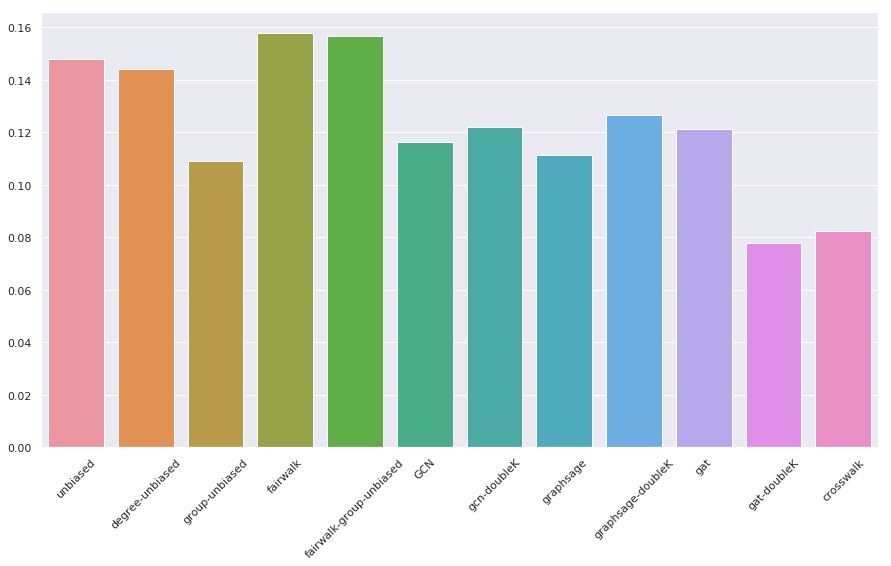

In [9]:
sns.set(rc = {'figure.figsize':(15,8)})
ax = sns.barplot(x=list(scores.keys()), y=list(scores.values()))
ax.set_xticklabels(ax.get_xticklabels(),rotation = 45)

In [10]:
import pickle as pkl
pkl.dump(rgraphs, open('/tmp/rgraphs.pkl', 'wb'))
pkl.dump(group_ids, open('/tmp/group_ids.pkl', 'wb'))
pkl.dump(embs, open('/tmp/embs.pkl', 'wb'))
